In [3]:
import os
import pandas as pd
from scipy.signal import butter, filtfilt
import numpy as np

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def reject_artifacts(df, eeg_columns, threshold=100):
    df[eeg_columns] = df[eeg_columns].applymap(lambda x: np.nan if abs(x) > threshold else x)
    df[eeg_columns] = df[eeg_columns].interpolate(method='linear', axis=0)
    return df

In [4]:
def load_and_preprocess_data(adhd_folder, control_folder):
    # Initialize an empty list to store data
    data_list = []
    
    # Function to load data from a folder and assign class labels
    def load_data_from_folder(folder, label):
        for filename in os.listdir(folder):
            if filename.endswith('.csv'):
                file_path = os.path.join(folder, filename)
                # Load the CSV file into a pandas DataFrame
                df = pd.read_csv(file_path)
                
                # Add a column for the class label (1 for ADHD, 0 for Control)
                df['Label'] = label
                
                # Add the filename as an identifier (optional)
                df['Patient_ID'] = filename
                
                # Append to the data list
                data_list.append(df)
    
    # Load ADHD and Control data
    load_data_from_folder(adhd_folder, label=1)  # ADHD labeled as 1
    load_data_from_folder(control_folder, label=0)  # Control labeled as 0
    
    # Combine all data into a single DataFrame
    combined_data = pd.concat(data_list, ignore_index=True)
    
    return combined_data


In [5]:
import mne
def apply_ica(df, eeg_columns, fs, exclude_components=None):
    eeg_data = df[eeg_columns].to_numpy()

    # Create MNE raw object
    info = mne.create_info(ch_names=eeg_columns, sfreq=fs, ch_types='eeg')
    raw = mne.io.RawArray(eeg_data.T, info)

    # Map channel numbers to standard 10-20 EEG channel names
    standard_10_20 = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 
                      'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
    mapping = dict(zip(eeg_columns, standard_10_20))
    
    # Rename the channels
    raw.rename_channels(mapping)

    # Add 10-20 EEG montage to the raw object
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

    # Bandpass filter within MNE (1-50 Hz)
    raw.filter(1, 50)
    
    # Perform ICA
    ica = mne.preprocessing.ICA(n_components=19, random_state=97, max_iter=800)
    ica.fit(raw)
    
    # Plot ICA components for manual inspection (optional)
    ica.plot_components()

    # Optionally exclude specific ICA components (manual or automatic)
    if exclude_components is not None:
        ica.exclude = exclude_components

    # Apply ICA to remove the excluded components
    raw_clean = ica.apply(raw)
    
    # Extract the cleaned EEG data
    cleaned_eeg_data = raw_clean.get_data().T
    
    # Convert back to DataFrame
    df_cleaned = pd.DataFrame(cleaned_eeg_data, columns=standard_10_20)
    df_cleaned['Label'] = df['Label'].values
    df_cleaned['Patient_ID'] = df['Patient_ID'].values
    
    return df_cleaned

In [6]:

def preprocess_data(df,fs=128):
    # Check for missing values and handle them (optional: you can drop or fill missing values)
    if df.isnull().values.any():
        print("Missing values")
        df.fillna(df.mean(), inplace=True)  # Fill missing values with mean (or use other strategy)
    else:
        print("No Missing values")
    
    # Extract the EEG signal columns (assuming all but 'Label' and 'Patient_ID' are EEG signals)
    eeg_columns = [col for col in df.columns if col not in ['Label', 'Patient_ID']]
    df[eeg_columns] = df[eeg_columns].apply(lambda x: bandpass_filter(x, 1, 50, fs))
    
    # Reject artifacts based on amplitude threshold (e.g., ±100 µV)
    df = reject_artifacts(df, eeg_columns, threshold=100)
    df_cleaned = apply_ica(df, eeg_columns, fs, exclude_components=[0])
    
    return df_cleaned


No Missing values


C:\Users\smrit\AppData\Local\Temp\ipykernel_4676\1650952413.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[eeg_columns] = df[eeg_columns].applymap(lambda x: np.nan if abs(x) > threshold else x)


Creating RawArray with float64 data, n_channels=19, n_times=965943
    Range : 0 ... 965942 =      0.000 ...  7546.422 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Fitting ICA took 25.5s.


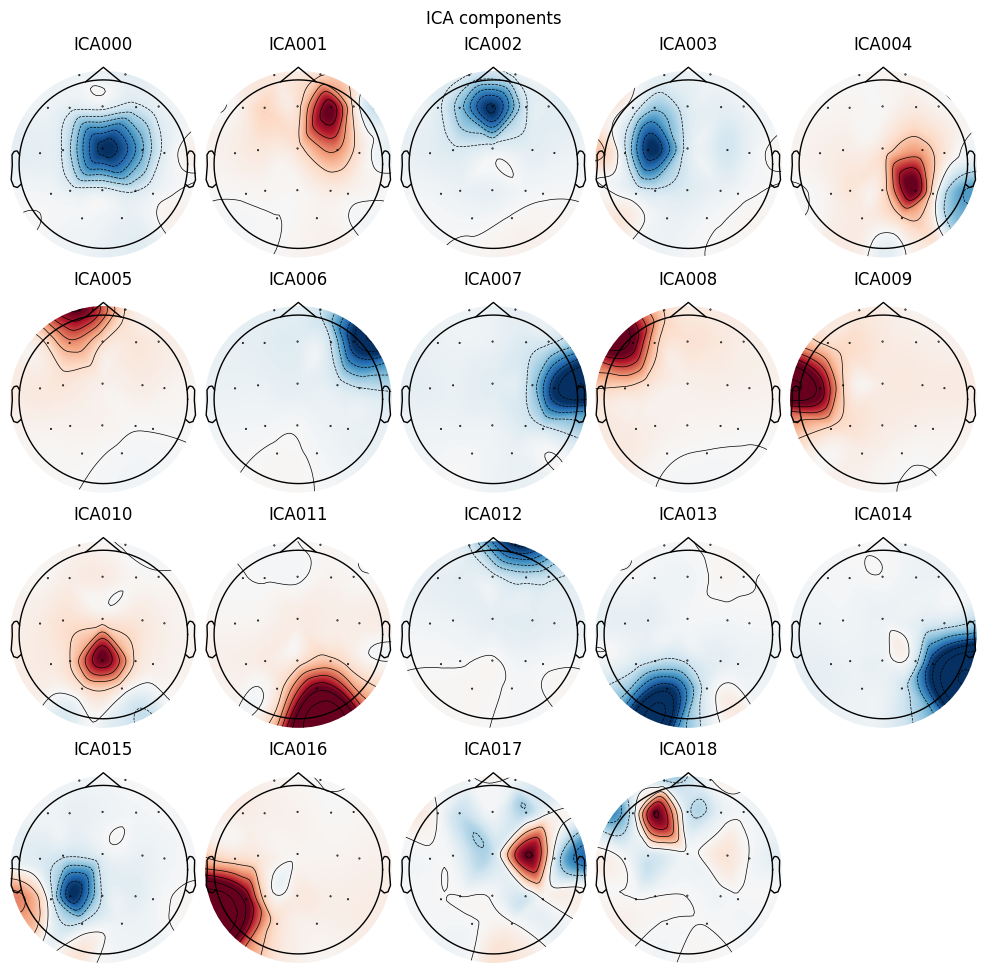

Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
        Fp1        Fp2         F3         F4         C3         C4         P3  \
0 -0.000027  -0.000056  -0.000066  -0.000117  -0.000103  -0.000282  -0.000054   
1  2.505235   7.988735 -23.155573  13.158681 -41.554782  19.788299 -45.323046   
2  5.202385  16.384989 -46.934837  27.432973 -80.473291  41.506415  13.996482   
3  5.342335  19.511770 -74.928989  29.924984 -66.207983  36.746148 -35.766868   
4  6.052312  23.632955 -58.987846  36.266236 -43.835454  37.646616 -47.394149   

          P4         O1         O2  ...         F8          T3         T4  \
0  -0.000095  -0.000012  -0.000042  ...  -0.000048   -0.000051  -0.000066   
1 -11.021028  23.793695  27.782912  ... -11.466725 -104.455994  -6.424960   
2 -21.867794  50.440562  -4.347586  ... -23.912986  -10.040215 -19.797432   
3 -21.443170  70.663297  -8.030366  ... -38.354829  -1

In [7]:
# Specify the folder paths (replace with your actual paths)
adhd_folder = 'Datacsv/ADHD'
control_folder = 'Datacsv/Control'

# Load and preprocess data
raw_data = load_and_preprocess_data(adhd_folder, control_folder)
preprocessed_data = preprocess_data(raw_data,fs=128)

# Check the preprocessed data
print(preprocessed_data.head())

# Optionally, save the preprocessed data to a new CSV file
preprocessed_data.to_csv('preprocessed_eeg_data.csv', index=False)

In [8]:
preprocessed_data.tail()

,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,...,F8,T3,T4,T5,T6,Fz,Cz,Pz,Label,Patient_ID
965938,-27.137588,2.125408,-32.246884,16.511296,12.419824,4.768595,-12.787013,-16.514789,-3.933812,125.319809,...,20.752895,-79.768728,-1.141644,7.574797,100.636155,-35.033016,0.614201,-13.089065,0,v60p_v60p.csv
965939,-21.589921,3.585618,-28.374788,29.711873,-35.173170,30.467801,-7.721576,-9.706321,-2.511823,117.814859,...,-7.808699,-80.552437,1.853763,6.326650,75.104598,-37.806971,-5.151991,-7.528087,0,v60p_v60p.csv
965940,-11.987286,4.855977,-0.410238,44.948681,-59.835571,49.633931,-2.807551,-1.579999,-1.133895,136.489816,...,7.352491,-85.101970,3.852589,5.012837,23.585101,-26.238774,-4.833619,-2.194595,0,v60p_v60p.csv
965941,-7.810892,-0.284239,-7.902044,-20.575988,-39.335272,-25.792696,-3.976920,-5.815977,-1.161354,-1.840550,...,22.487062,-89.587364,-1.102211,1.625012,20.795556,-18.642564,-8.037977,-4.203178,0,v60p_v60p.csv
965942,-0.000027,-0.000056,-0.000066,-0.000117,-0.000103,-0.000282,-0.000054,-0.000095,-0.000012,-0.000042,...,-0.000048,-0.000051,-0.000066,-0.000018,-0.000035,-0.000058,-0.000575,-0.000065,0,v60p_v60p.csv


In [9]:
len(preprocessed_data)

965943

In [10]:
import numpy as np
import pandas as pd
import os

# Memory-efficient Approximate Entropy function
def approximate_entropy(U, m, r):
    """
    Compute Approximate Entropy (ApEn) of a time series in a memory-efficient way.
    
    Parameters:
    U : array-like
        The input signal.
    m : int
        The length of compared run of data.
    r : float
        The filtering level (standard deviation * r).
    
    Returns:
    float
        Approximate entropy of the input signal.
    """
    def _maxdist(x_i, x_j):
        return np.max(np.abs(x_i - x_j))

    def _phi(m):
        N = len(U)
        x = np.array([U[i:i + m] for i in range(N - m + 1)])
        C = np.sum([np.sum(np.max(np.abs(x - x_i), axis=1) <= r) for x_i in x]) / (N - m + 1)
        return np.log(C / (N - m + 1))

    return abs(_phi(m) - _phi(m + 1))


In [11]:
# Function to calculate Approximate Entropy for a single preprocessed CSV file
def calculate_apen_for_file(preprocessed_file, m=2, r_factor=0.2):
    # Load the preprocessed EEG data
    df = pd.read_csv(preprocessed_file)
    
    # Get the label and Patient ID
    label = df['Label'].iloc[0]  # Assuming Label column exists
    patient_id = df['Patient_ID'].iloc[0]  # Assuming Patient_ID column exists
    
    # Calculate Approximate Entropy for each EEG channel
    eeg_columns = [col for col in df.columns if col not in ['Label', 'Patient_ID']]  # Exclude Label and ID
    apen_values = {}
    
    for col in eeg_columns:
        signal = df[col].values
        r = r_factor * np.std(signal)  # Set r based on the standard deviation of the signal
        apen_value = approximate_entropy(signal, m=m, r=r)
        apen_values[f'ApEn_{col}'] = apen_value
    
    # Create a result dictionary for this patient
    result = {
        'Patient_ID': patient_id,
        'Label': label,
        **apen_values  # Add ApEn values for each channel
    }
    
    # Convert the result to a DataFrame
    apen_df = pd.DataFrame([result])
    output_csv = 'ApproximatedData'
    # Save the ApEn results to a CSV file
    apen_df.to_csv(output_csv, index=False)
    print(f"Approximate Entropy results saved to {output_csv}")
    

In [12]:
# Example usage
preprocessed_file = 'preprocessed_eeg_data.csv'  # Preprocessed CSV file
calculate_apen_for_file(preprocessed_file, m=2, r_factor=0.2)

KeyboardInterrupt: 